In [ ]:
!unzip Data.zip

In [ ]:
!unzip weather.zip

In [ ]:
!unzip weather_forest_fire.zip

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from numpy import arange
import datetime
import seaborn as sns


Data Merging Part

In [ ]:
db_conn = sqlite3.connect("Data/FPA_FOD_20170508.sqlite")
wildfire = pd.read_sql_query ("select * from Fires where FIRE_YEAR>=2010", db_conn)
wildfire

In [ ]:
df = wildfire.groupby(["STATE"]).size().reset_index(name="size")
df

In [ ]:
test = wildfire[wildfire["STATE"] == "MT"].groupby(["FIRE_YEAR"]).size().reset_index(name="size")
test

In [ ]:
def get_datetime(row):
  year = row["FIRE_YEAR"]
  doy = row["DISCOVERY_DOY"]
  return datetime.datetime.strptime(f"{year} {doy}", '%Y %j')

wildfire["datetime"] = wildfire.apply(lambda row: get_datetime(row), axis=1)

In [ ]:
pd1 = wildfire[(wildfire["STATE"] == "NC") & (wildfire["FIRE_YEAR"] == 2010)].sort_values("datetime")["datetime"]
pd1

In [ ]:
def get_round_lat(row):
  lat = row["LATITUDE"]
  return round(lat, 0)

def get_round_lon(row):
  lon = row["LONGITUDE"]
  return round(lon, 0)

In [ ]:
wildfire["lat"] = wildfire.apply(lambda row: get_round_lat(row), axis=1)
wildfire["lon"] = wildfire.apply(lambda row: get_round_lon(row), axis=1)

In [ ]:
frames = []
temp1 = pd.read_csv("weather/MT-10-1-6.csv", sep=",")
temp2 = pd.read_csv("weather/MT-10-6-12.csv", sep=",")
temp3 = pd.read_csv("weather/MT-11-1-6.csv", sep=",")
temp4 = pd.read_csv("weather/MT-11-6-12.csv", sep=",")
temp5 = pd.read_csv("weather/MT-12-1-6.csv", sep=",")
temp6 = pd.read_csv("weather/MT-12-6-12.csv", sep=",")
temp7 = pd.read_csv("weather/MT-13-1-6.csv", sep=",")
temp8 = pd.read_csv("weather/MT-13-6-12.csv", sep=",")
temp9 = pd.read_csv("weather/MT-14-1-6.csv", sep=",")
temp10 = pd.read_csv("weather/MT-14-6-12.csv", sep=",")
temp11 = pd.read_csv("weather/MT-15-1-6.csv", sep=",")
temp12 = pd.read_csv("weather/MT-15-6-12.csv", sep=",")
weather = pd.concat([temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11, temp12])

In [ ]:
weather["lat"] = weather.apply(lambda row: get_round_lat(row), axis=1)
weather["lon"] = weather.apply(lambda row: get_round_lon(row), axis=1)

In [ ]:
weather = weather.drop_duplicates()

In [ ]:
weather

In [ ]:
weather["DATE"]

0         2010-01-01
1         2010-01-02
2         2010-01-03
3         2010-01-04
4         2010-01-05
             ...    
108516    2015-12-27
108517    2015-12-28
108518    2015-12-29
108519    2015-12-30
108520    2015-12-31
Name: DATE, Length: 1171507, dtype: object

In [ ]:
wildfire["datetime"]

0        2010-05-19
1        2010-06-08
2        2010-06-12
3        2010-06-14
4        2010-07-11
            ...    
450229   2015-09-26
450230   2015-10-05
450231   2015-05-02
450232   2015-10-14
450233   2015-03-14
Name: datetime, Length: 450234, dtype: datetime64[ns]

In [ ]:
weather["DATE"] = pd.to_datetime(weather["DATE"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
weather["DATE"]

0        2010-01-01
1        2010-01-02
2        2010-01-03
3        2010-01-04
4        2010-01-05
            ...    
108516   2015-12-27
108517   2015-12-28
108518   2015-12-29
108519   2015-12-30
108520   2015-12-31
Name: DATE, Length: 1171507, dtype: datetime64[ns]

In [ ]:
merged_df = wildfire.merge(weather, how="left", left_on=["lat", "lon", "datetime"], right_on=["lat", "lon", "DATE"])

In [ ]:
# merged_df[(merged_df["lat"] == 48.0) & (merged_df["lon"]==-108.0)]["TMIN"]
merged_df

In [ ]:
merged_df.to_csv("weather_forest_fire.csv")

EDA Part

In [ ]:
merged_df = pd.read_csv("weather_forest_fire.csv", sep=",")

In [ ]:
merged_df.sort_values(["FIRE_SIZE"])["FIRE_SIZE"]

320326         0.00001
413551         0.00010
437099         0.00010
526692         0.00010
338475         0.00100
              ...     
165595    314444.00000
209628    315578.80000
222664    461047.00000
92480     538049.00000
223973    558198.30000
Name: FIRE_SIZE, Length: 552269, dtype: float64

In [ ]:
merged_df["LOG_FIRE_SIZE"] = np.log(merged_df["FIRE_SIZE"])

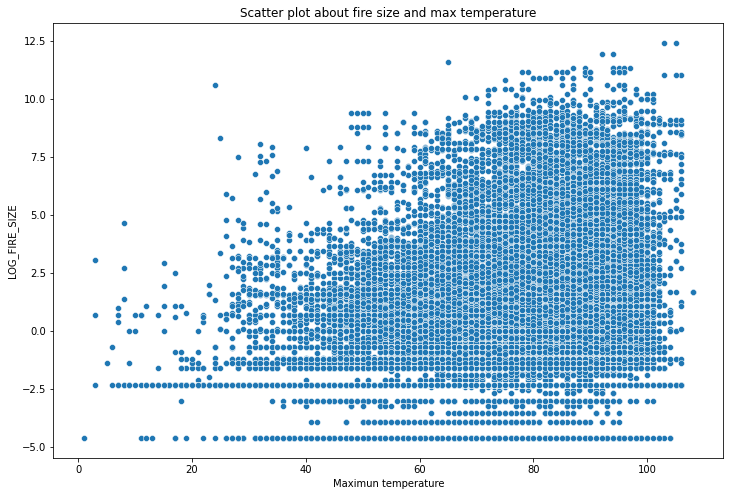

In [ ]:
# scatter plot about fire size and max temperature
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x="TMAX", y="LOG_FIRE_SIZE")
plt.xlabel("Maximun temperature")
plt.title("Scatter plot about fire size and max temperature")
plt.show()

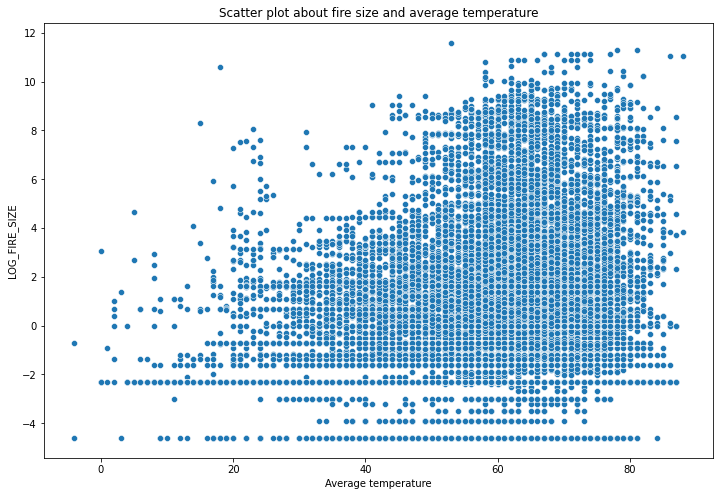

In [ ]:
# scatter plot about fire size and max temperature
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x="TAVG", y="LOG_FIRE_SIZE")
plt.xlabel("Average temperature")
plt.title("Scatter plot about fire size and average temperature")
plt.show()

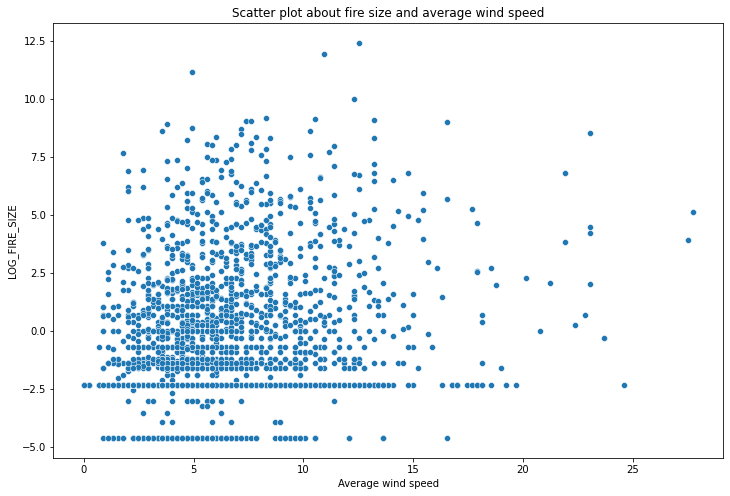

In [ ]:
# scatter plot about fire size and wind speed
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x="AWND", y="LOG_FIRE_SIZE")
plt.xlabel("Average wind speed")
plt.title("Scatter plot about fire size and average wind speed")
plt.show()

In [ ]:
count_wf = pd.DataFrame(merged_df.groupby(["TMAX", "TMIN"]).size()).reset_index()

In [ ]:
count_wf = count_wf.rename(columns={count_wf.columns[2]: 'count'})

In [ ]:
def heatmap_bins(data, fieldsxy, ncuts=30, aggarg='mean'):
    """Perform data.groupby using bin cuts along columns named in fieldsxy.
    Args:
        data     - pandas dataframe
        fieldsxy - list of column names along which to perform binned groupby
        ncuts    - number of cuts to perform for each field (see pd.cut)
        aggarg   - aggregation operation to perform, default: 'mean'
    Returns:
        grouped dataframe, ready for plotting via sns.heatmap(means['COLUMNAME'])
    """
    # based on: https://matthewmcgonagle.github.io/blog/2019/01/22/HeatmapBins
    cuts = pd.DataFrame({str(feature) + ' bins' : pd.cut(data[feature], ncuts) for feature in fieldsxy})
    means = data.join(cuts).groupby( list(cuts) ).agg(aggarg)
    means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
    # Reverse the order of the rows as the heatmap will print from top to bottom.
    means = means.iloc[::-1]
    return means

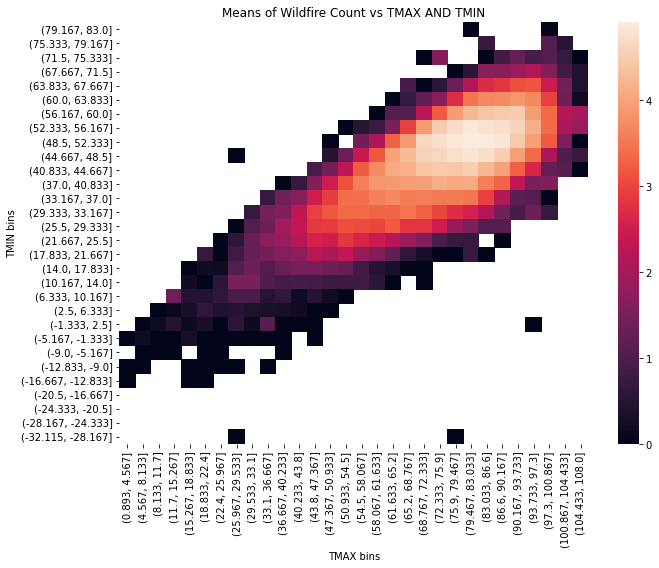

In [ ]:
with plt.rc_context({'figure.figsize': (10,8)}):
    means = heatmap_bins(count_wf[["TMAX", "TMIN",'count']],["TMAX", "TMIN"])
    plt.clf()
sns.heatmap(np.log(means['count']))
plt.title('Means of Wildfire Count vs TMAX AND TMIN')
plt.tight_layout()

In [ ]:
count_wf = pd.DataFrame(merged_df.groupby(["TAVG", "AWND"]).size()).reset_index()

In [ ]:
count_wf = count_wf.rename(columns={count_wf.columns[2]: 'count'})

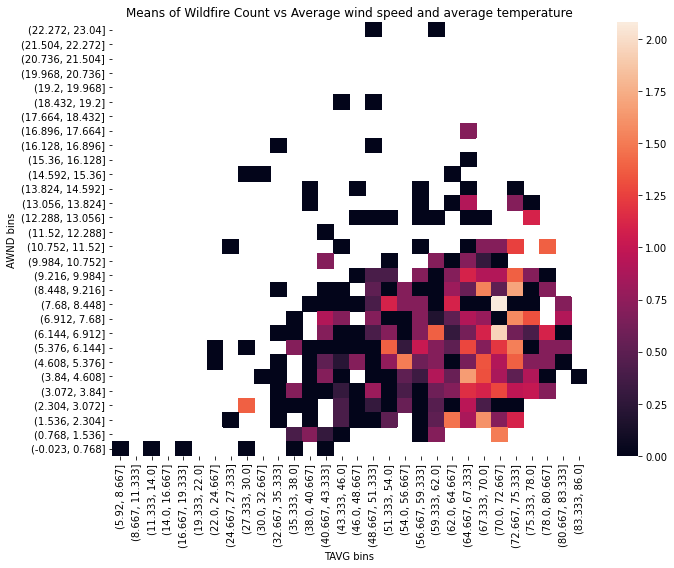

In [ ]:
with plt.rc_context({'figure.figsize': (10,8)}):
    means = heatmap_bins(count_wf[["TAVG", "AWND","count"]],["TAVG", "AWND"])
    plt.clf()
sns.heatmap(np.log(means['count']))
plt.title('Means of Wildfire Count vs Average wind speed and average temperature')
plt.tight_layout()